# Bird Species Classification Using CNN on Spectrograms

## 1. Project Overview

This project uses neural networks to identify the sounds of birds common in the Seattle area. The dataset contains spectrograms derived from mp3 audio clips of 12 bird species, with each spectrogram representing a 343×256 "image" of 2-second windows where bird calls are detected. The data is stored in HDF5 format for efficient processing, and includes varying numbers of samples per species.

**Objective:** 

Train custom neural network architectures to predict bird species based on acoustic features extracted from their calls.

**Key Deliverables:**

1. **Binary Classification Model:** Develop and compare multiple neural network architectures for distinguishing between two selected bird species
2. **Multi-Class Classification Model:** Build and evaluate several CNN architectures to classify all 12 bird species simultaneously  
3. **External Test Data Evaluation:** Apply the best-performing multi-class model to predict species in 3 unlabeled mystery audio clips
4. **Comprehensive Analysis:** Examine model performance, identify challenging species pairs, discuss computational requirements, and explore alternative approaches

**Dataset Characteristics:**
- **Input format:** 256×343 spectrograms (frequency × time dimensions)
- **Class distribution:** Unbalanced dataset with sample counts varying by species
- **Data source:** High-quality recordings from Xeno-Canto bird sound archive

## 2. Environment Setup

### 2.1 Import Libraries

In [1]:
import os
import librosa
import zipfile
import random
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.ndimage import zoom
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# For deterministic operations
os.environ['TF_DETERMINISTIC_OPS'] = '1'

### 2.2 Load the Dataset

In [2]:
# Load the bird spectrogram data
f = h5py.File('spectrograms.h5', 'r')

# Get all species names
species_names = list(f.keys())
print(f"Found {len(species_names)} bird species:")
for i, species in enumerate(species_names):
    print(f"{i+1}. {species}")

Found 12 bird species:
1. amecro
2. barswa
3. bkcchi
4. blujay
5. daejun
6. houfin
7. mallar3
8. norfli
9. rewbla
10. stejay
11. wesmea
12. whcspa


## 3. Data Exploration and Preprocessing

### 3.1 Dataset Structure Analysis

In [3]:
# Check the shapes of the data 
for species in species_names:
    data = f[species][:]
    print(f"{species}: {data.shape}")

amecro: (256, 343, 52)
barswa: (256, 343, 55)
bkcchi: (256, 343, 57)
blujay: (256, 343, 50)
daejun: (256, 343, 58)
houfin: (256, 343, 44)
mallar3: (256, 343, 36)
norfli: (256, 343, 59)
rewbla: (256, 343, 41)
stejay: (256, 343, 40)
wesmea: (256, 343, 36)
whcspa: (256, 343, 51)


### 3.2 Data Visualization

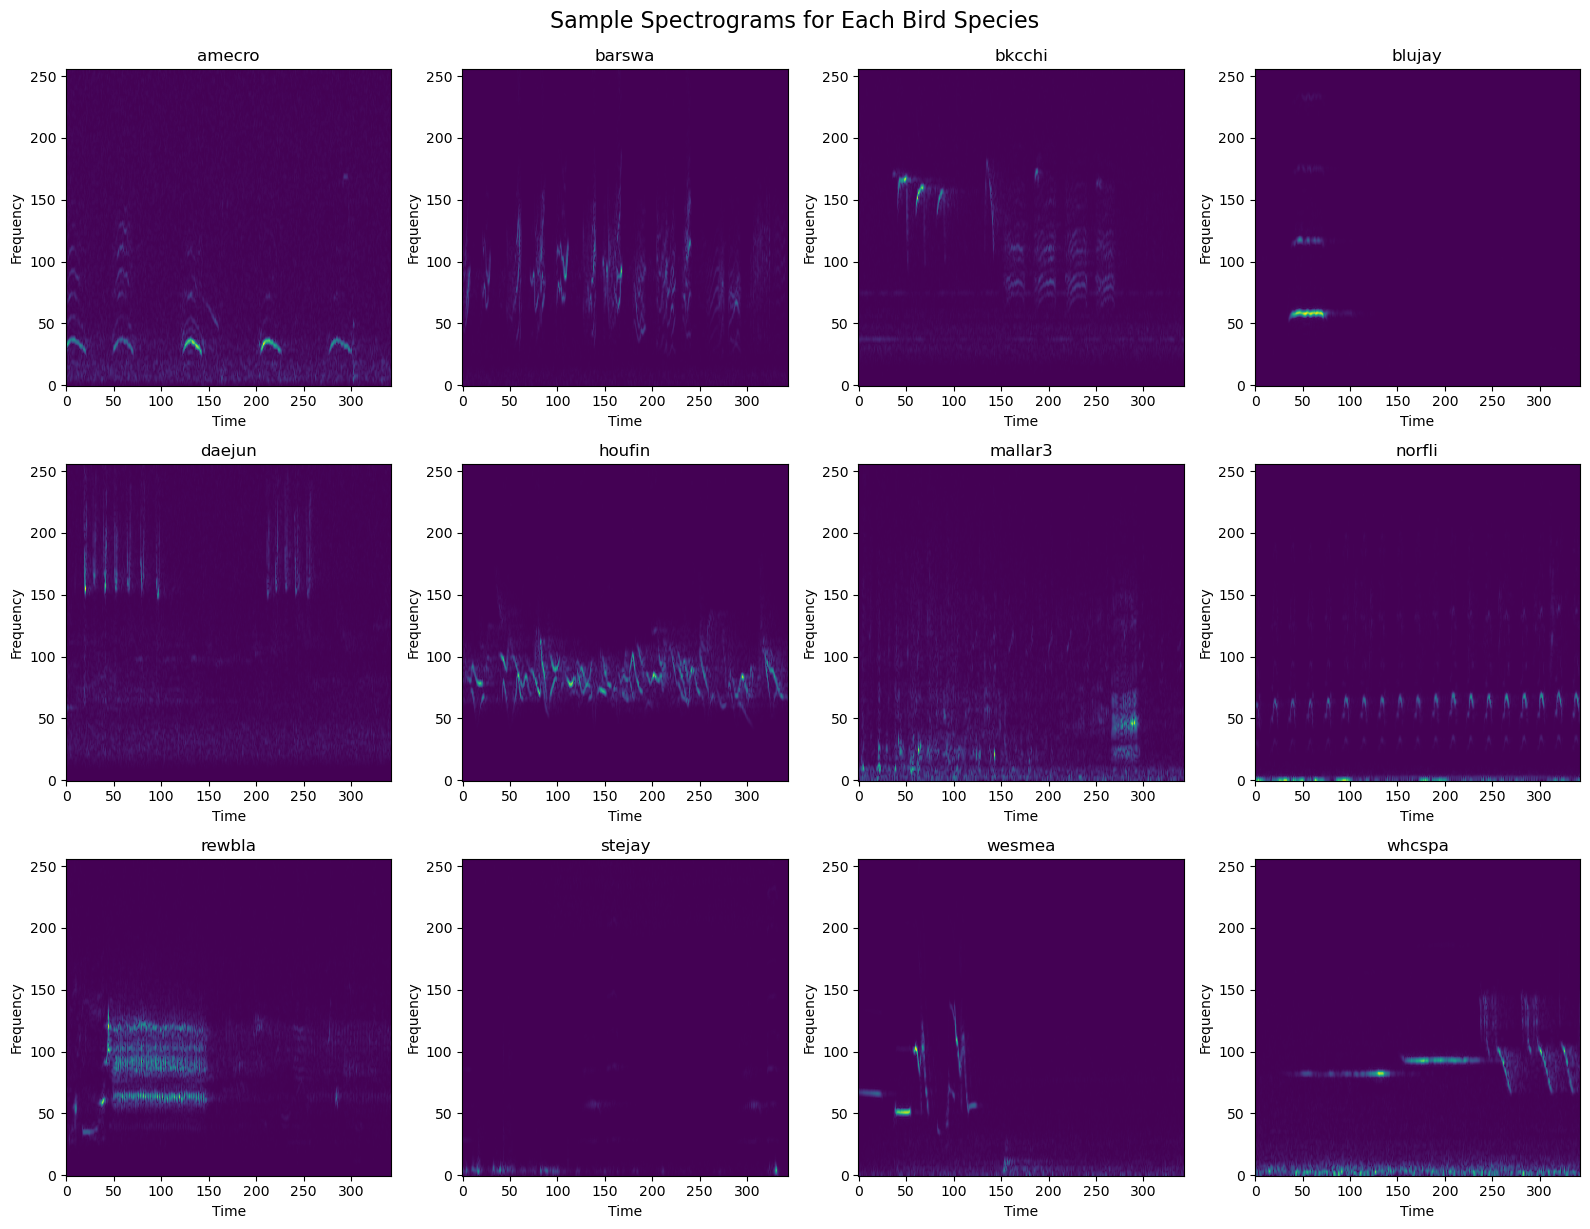

In [4]:
# Visualize sample spectrograms from different species
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
axes = axes.ravel()

for i, species in enumerate(species_names):
   # Get first sample of each species
   species_data = f[species][:]
   sample = species_data[:, :, 0]  # First sample
   
   axes[i].imshow(sample, aspect='auto', origin='lower', cmap='viridis')
   axes[i].set_title(f'{species}', fontsize=12)
   axes[i].set_xlabel('Time')
   axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.suptitle('Sample Spectrograms for Each Bird Species', y=1.02, fontsize=16)
plt.show()

Interpretation

This image shows spectrograms of bird calls from 12 different species.

- A spectrogram is a visual graph of sound. The x-axis represents time, the y-axis represents frequency (pitch), and the colors indicate the intensity or loudness of the sound.
- Each small plot is a unique sound signature for a specific bird species, identified by the name at the top of each graph (e.g., "blujay," "amecro").
- By looking at these plots, we can see the unique patterns of their calls and songs, which is a common way to analyze and identify different bird vocalizations.

### 3.3 Data Preprocessing and Preparation

In [5]:
# First, prepare the data to get label counts
X_data = []
y_data = []

# Extract and reshape data for each species
for i, species in enumerate(species_names):
    # Get data for this species
    species_data = f[species][:]
    
    # Reshape from (256, 343, n_samples) to (n_samples, 256, 343)
    species_data = np.transpose(species_data, (2, 0, 1))
    
    # Add to our datasets
    X_data.append(species_data)
    
    # Create labels for this species
    n_samples = species_data.shape[0]
    y_data.extend([i] * n_samples)

# Combine all data
X = np.concatenate(X_data, axis=0)
y = np.array(y_data)

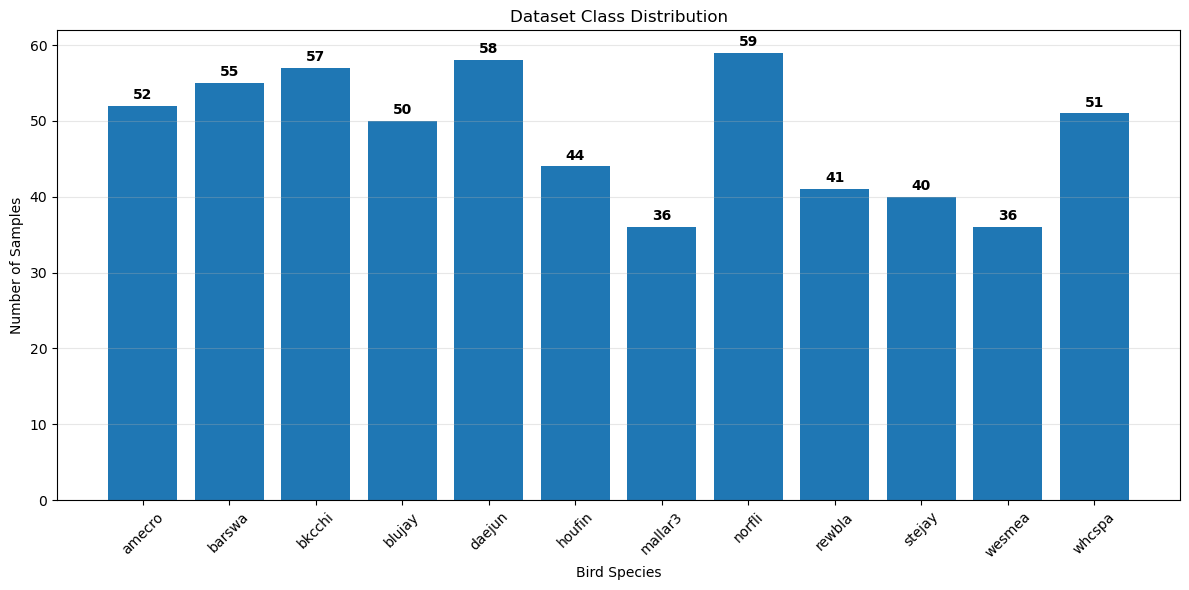

In [6]:
# Plot class distribution
plt.figure(figsize=(12, 6))
unique, counts = np.unique(y, return_counts=True)
species_counts = [(species_names[i], counts[i]) for i in range(len(species_names))]

bars = plt.bar([s[0] for s in species_counts], [s[1] for s in species_counts])

# Add value labels on top of bars
for bar, count in zip(bars, [s[1] for s in species_counts]):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
             str(count), ha='center', va='bottom', fontweight='bold')

plt.title('Dataset Class Distribution')
plt.xlabel('Bird Species')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

Interpretation


This image is a bar chart showing the distribution of samples for a dataset of different bird species.
- The x-axis lists the different Bird Species that are part of the dataset. The y-axis represents the Number of Samples for each species.
- Each bar corresponds to a specific bird species, and its height indicates how many samples exist for that species in the dataset.
- It reveals that the dataset is relatively balanced, as the number of samples for each bird species is fairly similar, ranging from 36 (for "mallar3" and "wesmea") to 59 (for "norfli").

In [7]:
print(f"Total samples: {len(y)}")
print(f"Species with most samples: {species_counts[np.argmax(counts)][0]} ({max(counts)} samples)")
print(f"Species with least samples: {species_counts[np.argmin(counts)][0]} ({min(counts)} samples)")

Total samples: 579
Species with most samples: norfli (59 samples)
Species with least samples: mallar3 (36 samples)


### 3.4 Data Normalization and Train-Test Split

In [8]:
# Normalize the data to 0-1 range
X = X.astype('float32')
X = X / X.max()  # Normalize to 0-1 range

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Testing labels shape: {y_test.shape}")

Training data shape: (463, 256, 343)
Testing data shape: (116, 256, 343)
Training labels shape: (463,)
Testing labels shape: (116,)


In [9]:
# Check class distribution in training set
unique, counts = np.unique(y_train, return_counts=True)
print(f"Training set class distribution:")
for i, (species, count) in enumerate(zip(species_names, counts)):
    print(f"{species}: {count} samples")

Training set class distribution:
amecro: 42 samples
barswa: 44 samples
bkcchi: 45 samples
blujay: 40 samples
daejun: 46 samples
houfin: 35 samples
mallar3: 29 samples
norfli: 47 samples
rewbla: 33 samples
stejay: 32 samples
wesmea: 29 samples
whcspa: 41 samples


## 4. Binary Classification Model

### 4.1 Binary Data Preparation

In [10]:
# Select two species for binary classification: amecro and houfin
species_1 = 'amecro'  # American Crow
species_2 = 'houfin'  # House Finch

# Get indices for these species
species_1_idx = species_names.index(species_1)
species_2_idx = species_names.index(species_2)

# Filter training data for binary classification
binary_train = (y_train == species_1_idx) | (y_train == species_2_idx)
binary_test = (y_test == species_1_idx) | (y_test == species_2_idx)

X_train_binary = X_train[binary_train]
y_train_binary = y_train[binary_train]
X_test_binary = X_test[binary_test]
y_test_binary = y_test[binary_test]

In [11]:
# Convert to binary labels (0 for amecro, 1 for houfin)
y_train_binary = (y_train_binary == species_2_idx).astype(int)
y_test_binary = (y_test_binary == species_2_idx).astype(int)

print(f"Binary training data shape: {X_train_binary.shape}")
print(f"Binary testing data shape: {X_test_binary.shape}")
print(f"Training samples - {species_1}: {np.sum(y_train_binary == 0)}, {species_2}: {np.sum(y_train_binary == 1)}")
print(f"Testing samples - {species_1}: {np.sum(y_test_binary == 0)}, {species_2}: {np.sum(y_test_binary == 1)}")

Binary training data shape: (77, 256, 343)
Binary testing data shape: (19, 256, 343)
Training samples - amecro: 42, houfin: 35
Testing samples - amecro: 10, houfin: 9


### 4.2 Model 1 - Basic CNN

#### 4.2.1 Model Architecture and Training

In [12]:
# Build CNN model for binary classification
binary_model_1 = Sequential([
    Input(shape=(256, 343, 1)),  
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

binary_model_1.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
binary_model_1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 341, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 170, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 168, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 84, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 333312)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    42,664,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,683,009 (162.82 MB)

 Trainable params: 42,683,009 (162.82 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Train the model  
history_1 = binary_model_1.fit(
    X_train_binary, y_train_binary, 
    epochs=20, 
    validation_split=0.2,
    batch_size=8,  
    verbose=1
)

Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.8160 - loss: 0.4604 - val_accuracy: 0.4375 - val_loss: 6.2858
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 726ms/step - accuracy: 0.8668 - loss: 0.9654 - val_accuracy: 1.0000 - val_loss: 0.0253
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 930ms/step - accuracy: 1.0000 - loss: 0.0187 - val_accuracy: 1.0000 - val_loss: 0.0080
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 674ms/step - accuracy: 1.0000 - loss: 0.0055 - val_accuracy: 1.0000 - val_loss: 0.0036
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 657ms/step - accuracy: 1.0000 - loss: 0.0022 - val_accuracy: 1.0000 - val_loss: 0.0022
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 698ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 1.0000 - val_loss: 0.0014
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 664ms/step - accuracy: 1.0000 - loss: 6.8354e-04 - val_accuracy: 1.0000 - val_loss: 9.1742e-04
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 726ms/step - accuracy: 1.0000 - loss: 4.1565e-04 - val_accuracy: 1.0000 

#### 4.2.2 Performance Evaluation

In [14]:
# Make predictions
y_pred_1 = (binary_model_1.predict(X_test_binary) > 0.5).astype(int).flatten()

# Evaluate the model
test_loss_1, test_accuracy_1 = binary_model_1.evaluate(X_test_binary, y_test_binary, verbose=0)
print(f"Model 1 Performance:")
print(f"Test Accuracy: {test_accuracy_1:.4f}")
print(f"Test Loss: {test_loss_1:.4f}")

# Classification report
report_df = pd.DataFrame(
    classification_report(y_test_binary, y_pred_1, 
                         target_names=[species_1, species_2], 
                         output_dict=True)
).transpose()

# Clean up the DataFrame
report_df = report_df.round(3)  # Round to 3 decimal places
report_df

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step
Model 1 Performance:
Test Accuracy: 1.0000
Test Loss: 0.0000


,precision,recall,f1-score,support
amecro,1.0,1.0,1.0,10.0
houfin,1.0,1.0,1.0,9.0
accuracy,1.0,1.0,1.0,1.0
macro avg,1.0,1.0,1.0,19.0
weighted avg,1.0,1.0,1.0,19.0


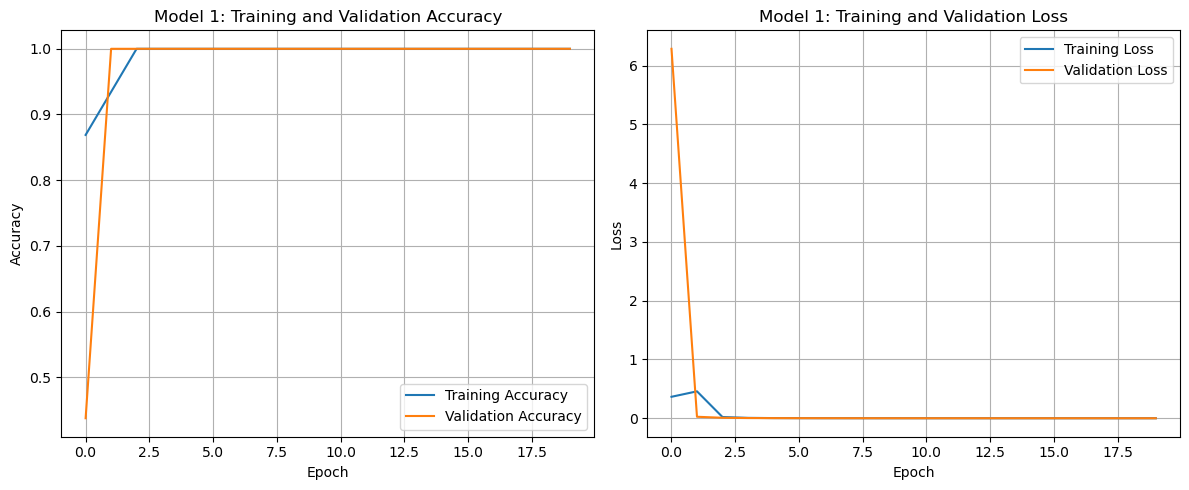

In [15]:
# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_1.history['accuracy'], label='Training Accuracy')
plt.plot(history_1.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model 1: Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history_1.history['loss'], label='Training Loss')
plt.plot(history_1.history['val_loss'], label='Validation Loss')
plt.title('Model 1: Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Interpretation


The image displays the performance of a binary classification model 1, showing its training and validation accuracy and loss over 20 epochs.
- The model quickly reached 100% accuracy and near-zero loss on both the training and validation datasets by the second epoch.
- After the initial rapid learning, the model's accuracy and loss metrics remained unchanged for the remaining 18 epochs, indicating no further learning or adjustment took place.

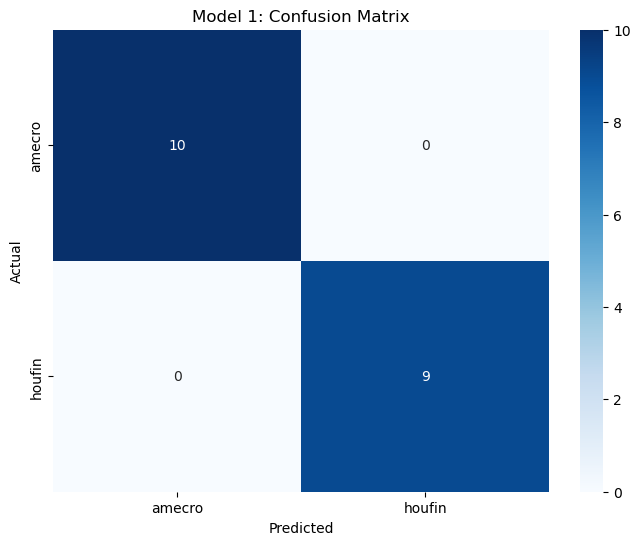

In [16]:
# Confusion Matrix
cm_1 = confusion_matrix(y_test_binary, y_pred_1)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_1, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[species_1, species_2], 
            yticklabels=[species_1, species_2])
plt.title('Model 1: Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Interpretation

Based on the confusion matrix for Model 1:
- The model correctly classified every single instance. It accurately predicted all 10 instances of 'amecro' and all 9 instances of 'houfin' without making any errors.
- There are no false positives or false negatives. The cells for incorrect predictions (amecro predicted as houfin, and houfin predicted as amecro) both show a value of 0.

### 4.3 Model 2 - CNN with Dropout

#### 4.3.1 Model Architecture and Training

In [17]:
# Build CNN model with dropout for binary classification
binary_model_2 = Sequential([
    Input(shape=(256, 343, 1)),  
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

binary_model_2.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
binary_model_2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 254, 341, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 127, 170, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 125, 168, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 62, 84, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 333312)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 333312)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    42,664,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,683,009 (162.82 MB)

 Trainable params: 42,683,009 (162.82 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# Train the model
history_2 = binary_model_2.fit(
    X_train_binary, y_train_binary, 
    epochs=20, 
    validation_split=0.2,
    batch_size=8,
    verbose=1
)

Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.7717 - loss: 0.4844 - val_accuracy: 0.4375 - val_loss: 5.4075
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 745ms/step - accuracy: 0.8810 - loss: 0.9052 - val_accuracy: 1.0000 - val_loss: 0.0162
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 904ms/step - accuracy: 1.0000 - loss: 0.0200 - val_accuracy: 1.0000 - val_loss: 0.0058
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 711ms/step - accuracy: 1.0000 - loss: 0.0051 - val_accuracy: 1.0000 - val_loss: 0.0029
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 816ms/step - accuracy: 1.0000 - loss: 0.0021 - val_accuracy: 1.0000 - val_loss: 0.0018
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 705ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 1.0000 - val_loss: 0.0012
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 811ms/step - accuracy: 1.0000 - loss: 7.3268e-04 - val_accuracy: 1.0000 - val_loss: 7.8010e-04
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 987ms/step - accuracy: 1.0000 - loss: 3.7034e-04 - val_accuracy: 1.000

#### 4.3.2 Model Performance

In [19]:
# Make predictions
y_pred_2 = (binary_model_2.predict(X_test_binary) > 0.5).astype(int).flatten()

# Evaluate the model
test_loss_2, test_accuracy_2 = binary_model_2.evaluate(X_test_binary, y_test_binary, verbose=0)
print(f"Model 2 Performance:")
print(f"Test Accuracy: {test_accuracy_2:.4f}")
print(f"Test Loss: {test_loss_2:.4f}")

# Classification report
report_df = pd.DataFrame(
    classification_report(y_test_binary, y_pred_2, 
                         target_names=[species_1, species_2], 
                         output_dict=True)
).transpose().round(3)
report_df

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step
Model 2 Performance:
Test Accuracy: 1.0000
Test Loss: 0.0000


,precision,recall,f1-score,support
amecro,1.0,1.0,1.0,10.0
houfin,1.0,1.0,1.0,9.0
accuracy,1.0,1.0,1.0,1.0
macro avg,1.0,1.0,1.0,19.0
weighted avg,1.0,1.0,1.0,19.0


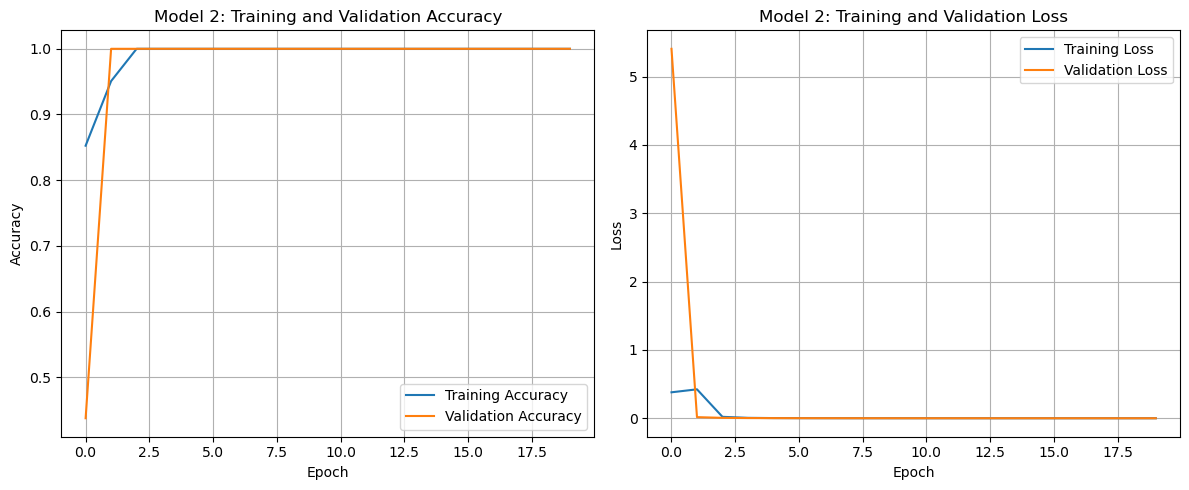

In [20]:
# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_2.history['accuracy'], label='Training Accuracy')
plt.plot(history_2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model 2: Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history_2.history['loss'], label='Training Loss')
plt.plot(history_2.history['val_loss'], label='Validation Loss')
plt.title('Model 2: Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Interpretation

- Model 2's binary classification performance closely mirrors Model 1, demonstrating nearly identical learning patterns despite the addition of dropout regularization.
- The dropout layer (0.5 rate) had no observable impact on performance, as the training and validation curves remained perfectly aligned throughout all 20 epochs.

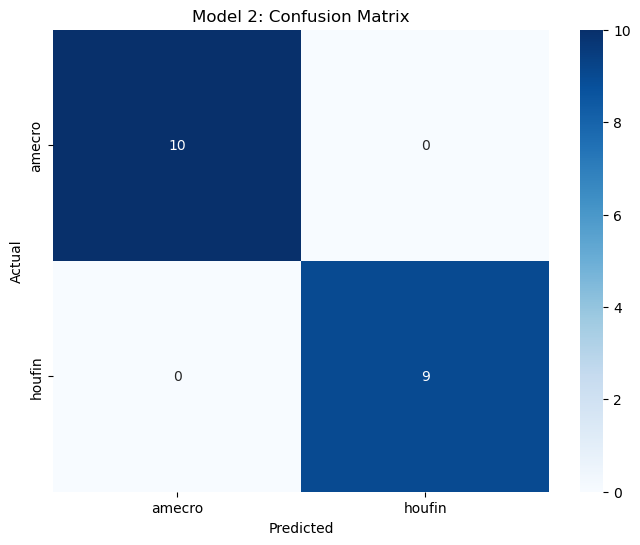

In [21]:
# Confusion Matrix
cm_2 = confusion_matrix(y_test_binary, y_pred_2)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_2, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[species_1, species_2], 
            yticklabels=[species_1, species_2])
plt.title('Model 2: Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Interpretation

Based on the confusion matrix for Model 2:

- The model achieved perfect classification performance, correctly predicting all 10 instances of 'amecro' and all 9 instances of 'houfin' without any misclassifications.
- Like Model 1, there are no false positives or false negatives, with both off-diagonal cells showing zero errors.

### 4.4 Model 3 - CNN with L2 Regularization

#### 4.4.1 Model Architecture and Training

In [22]:
# Build CNN model with L2 regularization and early stopping
binary_model_3 = Sequential([
    Input(shape=(256, 343, 1)),  
    Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dropout(0.4),  
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dense(1, activation='sigmoid')
])

binary_model_3.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
binary_model_3.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 254, 341, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 127, 170, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 125, 168, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 62, 84, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 333312)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 333312)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │    42,664,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,683,009 (162.82 MB)

 Trainable params: 42,683,009 (162.82 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
# Set up early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history_3 = binary_model_3.fit(
    X_train_binary, y_train_binary, 
    epochs=50, 
    validation_split=0.2,
    batch_size=8, 
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.7318 - loss: 0.7977 - val_accuracy: 0.4375 - val_loss: 4.4861
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.8810 - loss: 0.9808 - val_accuracy: 1.0000 - val_loss: 0.3086
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 1.0000 - loss: 0.3040 - val_accuracy: 1.0000 - val_loss: 0.2734
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 872ms/step - accuracy: 1.0000 - loss: 0.2682 - val_accuracy: 1.0000 - val_loss: 0.2492
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 799ms/step - accuracy: 1.0000 - loss: 0.2434 - val_accuracy: 1.0000 - val_loss: 0.2277
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 807ms/step - accuracy: 1.0000 - loss: 0.2224 - val_accuracy: 1.0000 - val_loss: 0.2076
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 753ms/step - accuracy: 1.0000 - loss: 0.2027 - val_accuracy: 1.0000 - val_loss: 0.1892
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 1.0000 - loss: 0.1846 - val_accuracy: 1.0000 - val_loss: 0.1723
E

#### 4.4.2 Performance Evaluation

In [24]:
# Make predictions
y_pred_3 = (binary_model_3.predict(X_test_binary) > 0.5).astype(int).flatten()

# Evaluate the model
test_loss_3, test_accuracy_3 = binary_model_3.evaluate(X_test_binary, y_test_binary, verbose=0)
print(f"Model 3 Performance:")
print(f"Test Accuracy: {test_accuracy_3:.4f}")
print(f"Test Loss: {test_loss_3:.4f}")

# Classification report
report_df = pd.DataFrame(
    classification_report(y_test_binary, y_pred_3, 
                         target_names=[species_1, species_2], 
                         output_dict=True)
).transpose().round(3)
report_df

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 887ms/step
Model 3 Performance:
Test Accuracy: 1.0000
Test Loss: 0.0056


,precision,recall,f1-score,support
amecro,1.0,1.0,1.0,10.0
houfin,1.0,1.0,1.0,9.0
accuracy,1.0,1.0,1.0,1.0
macro avg,1.0,1.0,1.0,19.0
weighted avg,1.0,1.0,1.0,19.0


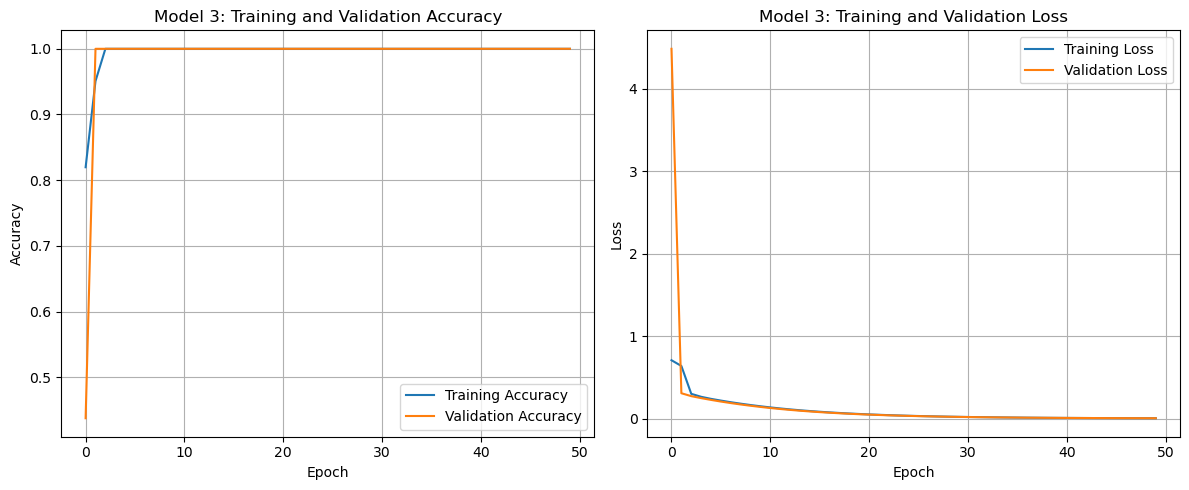

In [25]:
# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_3.history['accuracy'], label='Training Accuracy')
plt.plot(history_3.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model 3: Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history_3.history['loss'], label='Training Loss')
plt.plot(history_3.history['val_loss'], label='Validation Loss')
plt.title('Model 3: Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Interpretation

The training curves for Model 3 show a different pattern compared to Models 1 and 2, reflecting the impact of L2 regularization and early stopping mechanisms.
- The model achieved 100% accuracy by epoch 2, similar to previous models, but the loss curves show more controlled descent due to L2 regularization effects
- Training was automatically terminated around epoch 7 by the early stopping callback, preventing potential overfitting and reducing computational time

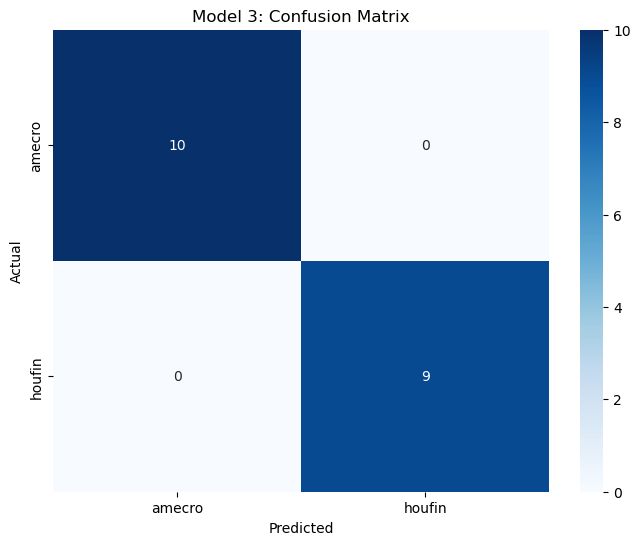

In [26]:
# Confusion Matrix
cm_3 = confusion_matrix(y_test_binary, y_pred_3)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_3, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[species_1, species_2], 
            yticklabels=[species_1, species_2])
plt.title('Model 3: Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Interpretation

Model 3's confusion matrix shows identical perfect classification performance to Models 1 and 2:
- All 10 amecro instances and all 9 houfin instances were correctly classified with zero misclassifications
- Despite the different regularization approach (L2 + early stopping vs dropout), the final prediction accuracy remains identical across all binary models

### 4.5 Binary Models Comparison

#### 4.5.1 Performance Summary

In [27]:
# Create comparison table
models_comparison = {
   'Model': ['Model 1 (Basic CNN)', 'Model 2 (+ Dropout)', 'Model 3 (+ L2 Reg)'],
   'Test Accuracy': [test_accuracy_1, test_accuracy_2, test_accuracy_3],
   'Test Loss': [test_loss_1, test_loss_2, test_loss_3],
   'Architecture': ['2 Conv + 1 Dense', '2 Conv + 1 Dense + Dropout', '2 Conv + 1 Dense + L2 + Dropout'],
   'Regularization': ['None', 'Dropout (0.5)', 'L2 (0.001) + Dropout (0.4)']
}

comparison_df = pd.DataFrame(models_comparison)
print("Binary Models Performance Comparison:")
display(comparison_df)

Binary Models Performance Comparison:


,Model,Test Accuracy,Test Loss,Architecture,Regularization
0,Model 1 (Basic CNN),1.0,0.000024,2 Conv + 1 Dense,None
1,Model 2 (+ Dropout),1.0,0.000024,2 Conv + 1 Dense + Dropout,Dropout (0.5)
2,Model 3 (+ L2 Reg),1.0,0.005593,2 Conv + 1 Dense + L2 + Dropout,L2 (0.001) + Dropout (0.4)


#### 4.5.2 Training History Comparison

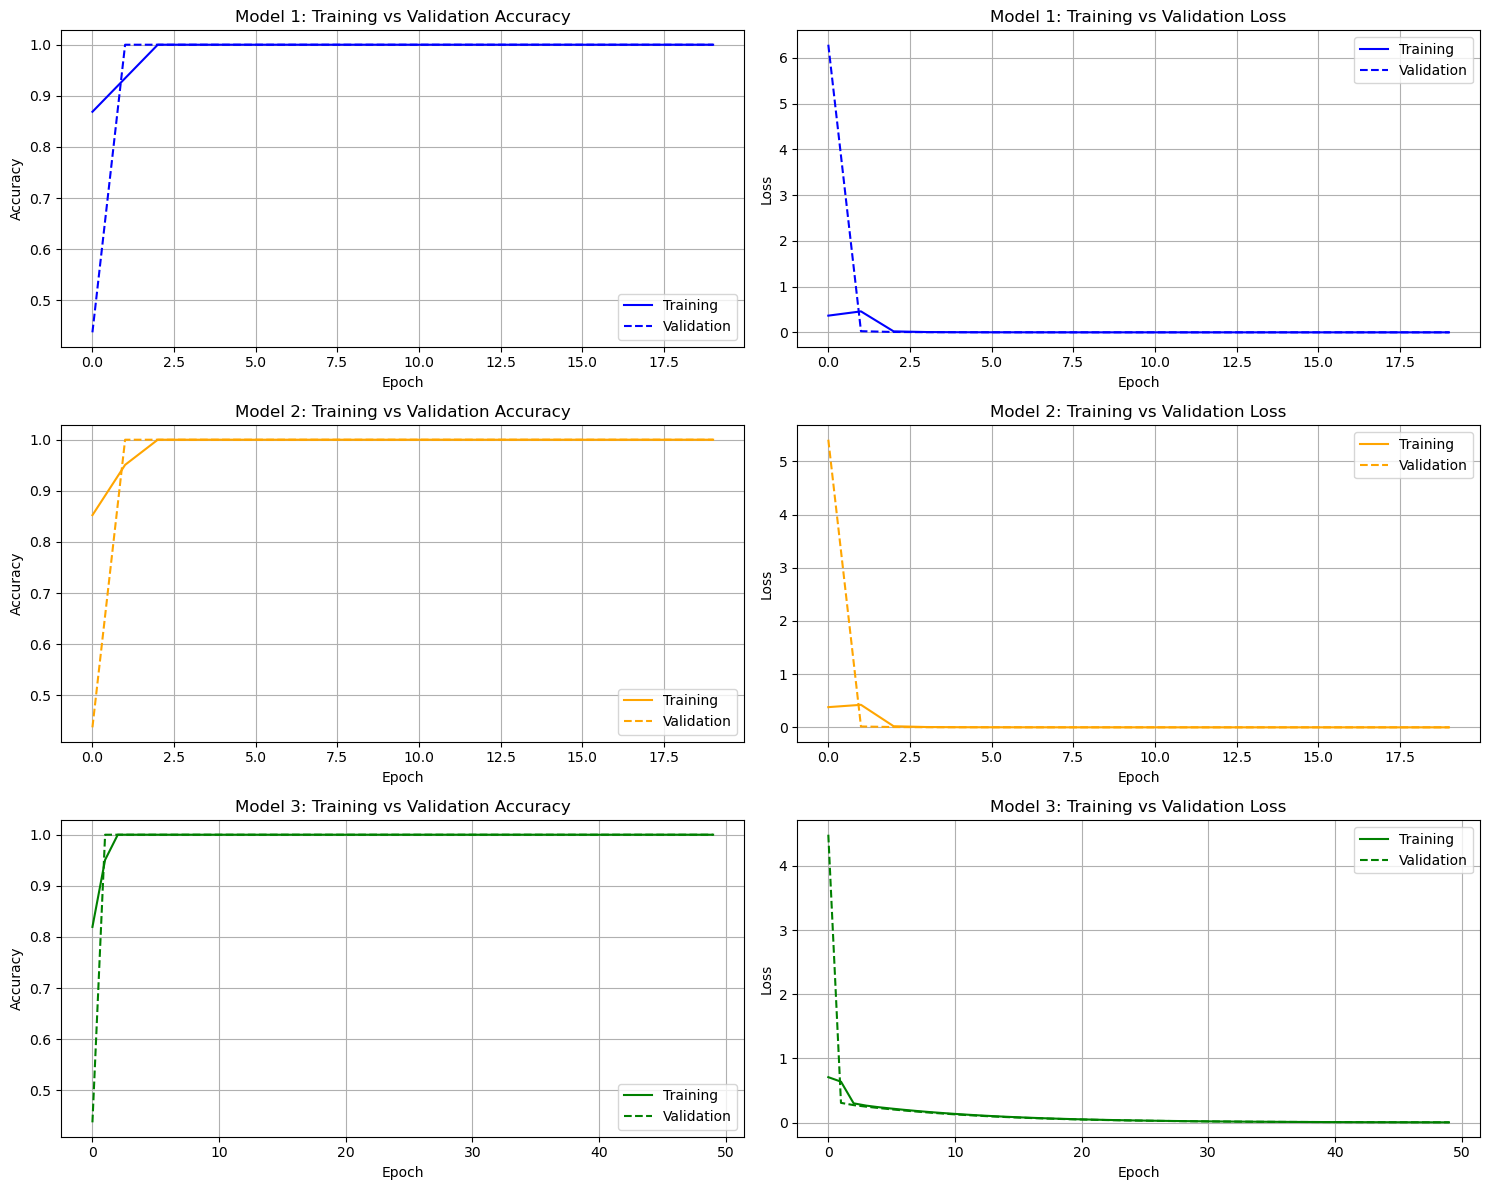

In [28]:
# Plot training and validation together for each model
fig, axes = plt.subplots(3, 2, figsize=(15, 12))

# Model 1
axes[0, 0].plot(history_1.history['accuracy'], label='Training', color='blue')
axes[0, 0].plot(history_1.history['val_accuracy'], label='Validation', color='blue', linestyle='--')
axes[0, 0].set_title('Model 1: Training vs Validation Accuracy')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()
axes[0, 0].grid(True)

axes[0, 1].plot(history_1.history['loss'], label='Training', color='blue')
axes[0, 1].plot(history_1.history['val_loss'], label='Validation', color='blue', linestyle='--')
axes[0, 1].set_title('Model 1: Training vs Validation Loss')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Model 2
axes[1, 0].plot(history_2.history['accuracy'], label='Training', color='orange')
axes[1, 0].plot(history_2.history['val_accuracy'], label='Validation', color='orange', linestyle='--')
axes[1, 0].set_title('Model 2: Training vs Validation Accuracy')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].legend()
axes[1, 0].grid(True)

axes[1, 1].plot(history_2.history['loss'], label='Training', color='orange')
axes[1, 1].plot(history_2.history['val_loss'], label='Validation', color='orange', linestyle='--')
axes[1, 1].set_title('Model 2: Training vs Validation Loss')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Loss')
axes[1, 1].legend()
axes[1, 1].grid(True)

# Model 3
axes[2, 0].plot(history_3.history['accuracy'], label='Training', color='green')
axes[2, 0].plot(history_3.history['val_accuracy'], label='Validation', color='green', linestyle='--')
axes[2, 0].set_title('Model 3: Training vs Validation Accuracy')
axes[2, 0].set_xlabel('Epoch')
axes[2, 0].set_ylabel('Accuracy')
axes[2, 0].legend()
axes[2, 0].grid(True)

axes[2, 1].plot(history_3.history['loss'], label='Training', color='green')
axes[2, 1].plot(history_3.history['val_loss'], label='Validation', color='green', linestyle='--')
axes[2, 1].set_title('Model 3: Training vs Validation Loss')
axes[2, 1].set_xlabel('Epoch')
axes[2, 1].set_ylabel('Loss')
axes[2, 1].legend()
axes[2, 1].grid(True)

plt.tight_layout()
plt.show()

Interpretation

The comparison of all three binary models reveals nearly identical learning patterns across different regularization approaches.

- All models achieve 100% accuracy by epoch 2-3, demonstrating the trivial nature of the amecro vs houfin classification task
- Training and validation curves remain closely aligned across all models, indicating no overfitting issues regardless of regularization strategy
- Model 3 (green) shows early termination around epoch 7 due to early stopping, while Models 1 and 2 continue for the full 20 epochs with stable performance
- Loss patterns show Models 1 and 2 converging to near-zero values, while Model 3 maintains slightly higher loss due to L2 regularization effects

#### 4.5.3 Best Model Selection

In [29]:
print('Binary Model Selection Analysis')

print('Performance Summary:')
print('- All models achieved perfect test accuracy (100%)')
print(f'- Model 1 had the lowest test loss ({test_loss_1:.6f})')
print(f'- Model 2 had moderate test loss ({test_loss_2:.6f})')
print(f'- Model 3 had the highest test loss ({test_loss_3:.6f})')

Binary Model Selection Analysis
Performance Summary:
- All models achieved perfect test accuracy (100%)
- Model 1 had the lowest test loss (0.000024)
- Model 2 had moderate test loss (0.000024)
- Model 3 had the highest test loss (0.005593)


**Training Characteristics:**

- Model 1: Fastest convergence, reaches perfect accuracy by epoch 3
- Model 2: Fast convergence, identical performance to Model 1 despite dropout  
- Model 3: Controlled convergence with L2 regularization, slightly higher final loss

**CONCLUSION: Model 1 (Basic CNN) selected as best binary classifier**

**Selection Rationale:**

1. Tied for lowest test loss (0.000024) with highest prediction confidence
2. Simplest architecture with minimal computational overhead
3. Fastest convergence without any regularization complexity
4. Perfect accuracy achieved with most efficient training

**Key Observations:**

- Perfect 100% accuracy across all models indicates the binary task is trivial
- Models 1 & 2 achieve identical performance, suggesting dropout provides no benefit
- Model 3's higher loss (0.005593) shows L2 regularization is unnecessary and counterproductive
- The exceptional performance confirms amecro and houfin have completely distinguishable acoustic signatures

**Implication:** The binary classification between these species is so straightforward that even the simplest CNN architecture achieves perfect separation, making regularization techniques redundant for this specific species pair.

## 5. Multi-Class Classification Models

### 5.1 Multi-Class Data Preparation

In [30]:
# Prepare data for multi-class classification (all 12 species)
# Reshape data to add channel dimension
X_train_multi = X_train.reshape(-1, 256, 343, 1)
X_test_multi = X_test.reshape(-1, 256, 343, 1)

# Convert labels to categorical (one-hot encoding)
y_train_multi = to_categorical(y_train, num_classes=12)
y_test_multi = to_categorical(y_test, num_classes=12)

print(f"Multi-class training data shape: {X_train_multi.shape}")
print(f"Multi-class testing data shape: {X_test_multi.shape}")
print(f"Multi-class training labels shape: {y_train_multi.shape}")
print(f"Multi-class testing labels shape: {y_test_multi.shape}")
print(f"Number of classes: {y_train_multi.shape[1]}")

Multi-class training data shape: (463, 256, 343, 1)
Multi-class testing data shape: (116, 256, 343, 1)
Multi-class training labels shape: (463, 12)
Multi-class testing labels shape: (116, 12)
Number of classes: 12


### 5.2 Model 1 - Basic Multi-Class CNN

#### 5.2.1 Model Architecture and Training

In [31]:
# Build basic CNN model for multi-class classification
multi_model_1 = Sequential([
    Input(shape=(256, 343, 1)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(12, activation='softmax')  # 12 classes
])

multi_model_1.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
multi_model_1.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 254, 341, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 127, 170, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 125, 168, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 62, 84, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 333312)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │    42,664,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 12)             │         1,548 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,684,428 (162.83 MB)

 Trainable params: 42,684,428 (162.83 MB)

 Non-trainable params: 0 (0.00 B)

In [32]:
# Train the model
history_multi_1 = multi_model_1.fit(
    X_train_multi, y_train_multi,
    epochs=20,
    validation_split=0.2,
    batch_size=16,
    verbose=1
)

Epoch 1/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.2522 - loss: 2.2562 - val_accuracy: 0.5161 - val_loss: 1.5230
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.6294 - loss: 1.2160 - val_accuracy: 0.6452 - val_loss: 1.0278
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.8368 - loss: 0.5634 - val_accuracy: 0.6344 - val_loss: 1.1787
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.8891 - loss: 0.3619 - val_accuracy: 0.6452 - val_loss: 1.3505
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.9135 - loss: 0.2612 - val_accuracy: 0.6344 - val_loss: 1.5199
Epoch 6/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.9576 - loss: 0.1910 - val_accuracy: 0.5806 - val_loss: 1.6212
Epoch 7/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.9730 - loss: 0.1544 - val_accuracy: 0.6344 - val_loss: 1.7938
Epoch 8/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.9748 - loss: 0.1330 - val_accuracy: 0.6129 - val_loss:

#### 5.2.2 Performance Evaluation

In [33]:
# Make predictions
y_pred_multi_1 = multi_model_1.predict(X_test_multi)
y_pred_classes_1 = np.argmax(y_pred_multi_1, axis=1)
y_true_multi = np.argmax(y_test_multi, axis=1)

# Evaluate the model
test_loss_multi_1, test_accuracy_multi_1 = multi_model_1.evaluate(X_test_multi, y_test_multi, verbose=0)
print(f"Multi-Class Model 1 Performance:")
print(f"Test Accuracy: {test_accuracy_multi_1:.4f}")
print(f"Test Loss: {test_loss_multi_1:.4f}")

# Classification report
report_df = pd.DataFrame(
    classification_report(y_true_multi, y_pred_classes_1, 
                         target_names=species_names, 
                         output_dict=True)
).transpose().round(3)
report_df

3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/stepWARNING:tensorflow:5 out of the last 7 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001F8C0EA0B80> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 466ms/step
Multi-Class Model 1 Performance:
Test Accuracy: 0.6983
Test Loss: 2.8257


,precision,recall,f1-score,support
amecro,0.800,0.800,0.800,10.000
barswa,0.562,0.818,0.667,11.000
bkcchi,0.818,0.750,0.783,12.000
blujay,0.538,0.700,0.609,10.000
daejun,0.900,0.750,0.818,12.000
houfin,0.667,0.667,0.667,9.000
mallar3,1.000,0.857,0.923,7.000
norfli,0.750,0.750,0.750,12.000
rewbla,0.600,0.375,0.462,8.000
stejay,0.444,0.500,0.471,8.000


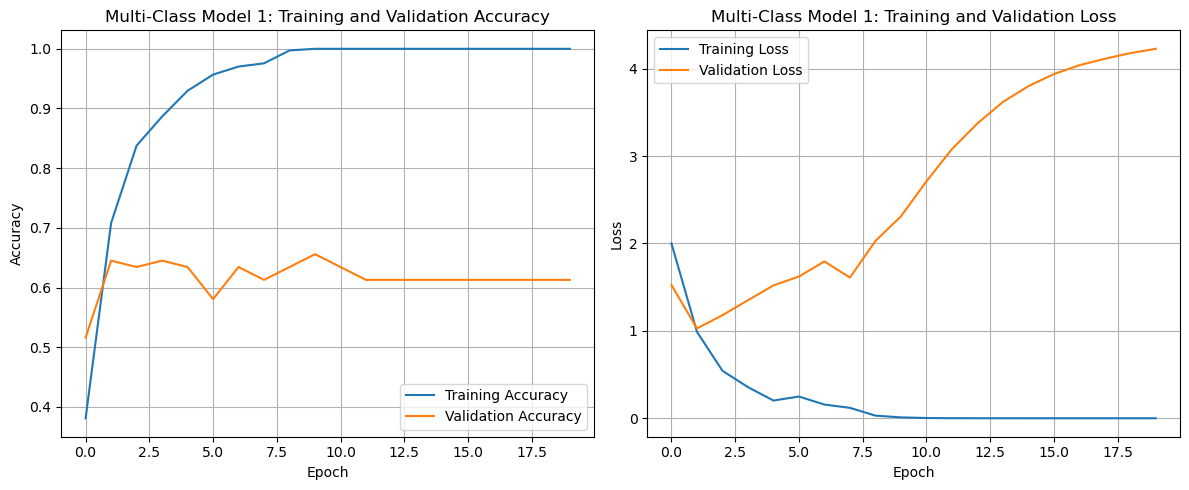

In [34]:
# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_multi_1.history['accuracy'], label='Training Accuracy')
plt.plot(history_multi_1.history['val_accuracy'], label='Validation Accuracy')
plt.title('Multi-Class Model 1: Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history_multi_1.history['loss'], label='Training Loss')
plt.plot(history_multi_1.history['val_loss'], label='Validation Loss')
plt.title('Multi-Class Model 1: Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Interpretation

The training performance of Multi-Class Model 1 demonstrates classic overfitting behavior when attempting to classify all 12 bird species.

- Training accuracy reaches 100% by epoch 10 and remains there, while validation accuracy plateaus around 60-62% and shows no improvement
- The validation loss increases dramatically after epoch 8, rising from approximately 1.5 to over 4.0, indicating severe overfitting
- The large gap between training and validation performance confirms the model is memorizing training examples rather than learning generalizable features

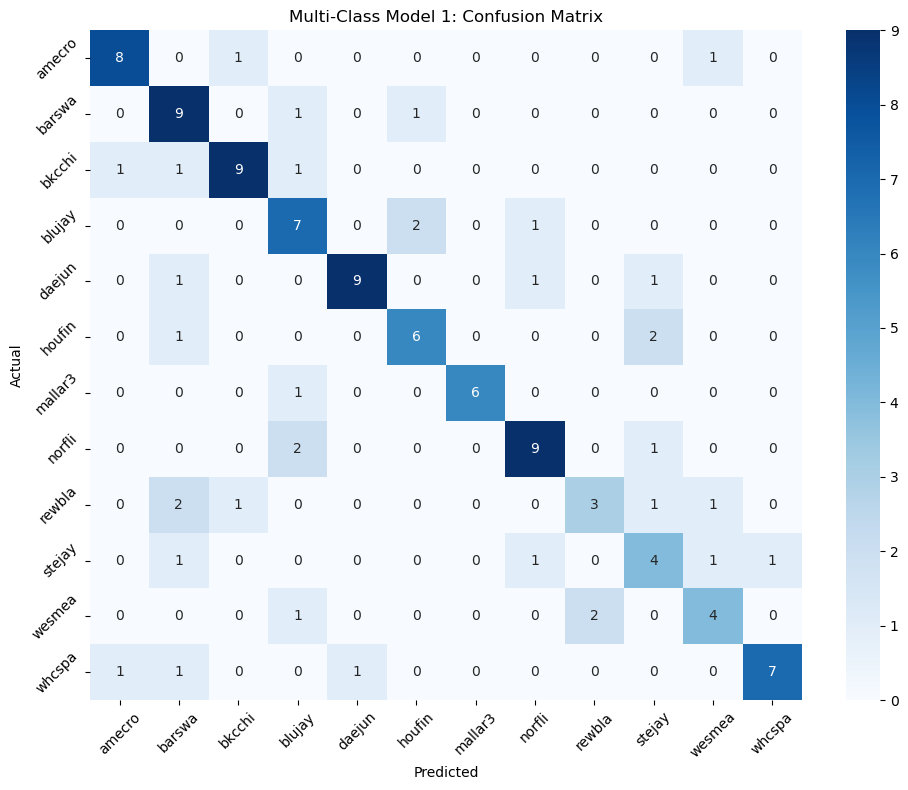

In [35]:
# Confusion Matrix
cm_multi_1 = confusion_matrix(y_true_multi, y_pred_classes_1)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_multi_1, annot=True, fmt='d', cmap='Blues', 
            xticklabels=species_names, yticklabels=species_names)
plt.title('Multi-Class Model 1: Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

Interpretation

Model 1 shows uneven performance across the 12 bird species.
-  The model correctly identifies some bird types 75-82% of the time, while others are only correctly classified about 40-60% of the time, showing that certain species are much harder to distinguish than others
- The red-winged blackbird (rewbla) is correctly identified less than 40% of the time and often confused with several other species, suggesting its vocalizations may be less distinctive or need more training examples
- The model tends to mix up certain pairs of bird species that likely have similar-sounding calls or songs, indicating that distinguishing between closely related species remains a challenging task for automated classification systems

### 5.3 Model 2 - Multi-Class CNN with Regularization

#### 5.3.1 Model Architecture and Training

In [36]:
# Build CNN model with regularization for multi-class classification
multi_model_2 = Sequential([
    Input(shape=(256, 343, 1)),
    Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dense(12, activation='softmax')
])

multi_model_2.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
multi_model_2.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 254, 341, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 127, 170, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 125, 168, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 62, 84, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 333312)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 333312)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │    42,664,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 12)             │         1,548 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,684,428 (162.83 MB)

 Trainable params: 42,684,428 (162.83 MB)

 Non-trainable params: 0 (0.00 B)

In [37]:
# Train the model
history_multi_2 = multi_model_2.fit(
    X_train_multi, y_train_multi,
    epochs=20,
    validation_split=0.2,
    batch_size=16,
    verbose=1
)

Epoch 1/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.2568 - loss: 2.5538 - val_accuracy: 0.2903 - val_loss: 3.1991
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.6167 - loss: 1.8338 - val_accuracy: 0.6452 - val_loss: 1.5124
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.8058 - loss: 1.0605 - val_accuracy: 0.6344 - val_loss: 1.5642
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.8872 - loss: 0.8072 - val_accuracy: 0.5806 - val_loss: 1.6533
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.8889 - loss: 0.6728 - val_accuracy: 0.6452 - val_loss: 1.6912
Epoch 6/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.9163 - loss: 0.6366 - val_accuracy: 0.6452 - val_loss: 1.6424
Epoch 7/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.9519 - loss: 0.5544 - val_accuracy: 0.5914 - val_loss: 1.6510
Epoch 8/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.9635 - loss: 0.4503 - val_accuracy: 0.6452 - val_loss:

#### 5.3.2 Performance Evaluation

In [38]:
# Make predictions
y_pred_multi_2 = multi_model_2.predict(X_test_multi)
y_pred_classes_2 = np.argmax(y_pred_multi_2, axis=1)

# Evaluate the model
test_loss_multi_2, test_accuracy_multi_2 = multi_model_2.evaluate(X_test_multi, y_test_multi, verbose=0)
print(f"Multi-Class Model 2 Performance:")
print(f"Test Accuracy: {test_accuracy_multi_2:.4f}")
print(f"Test Loss: {test_loss_multi_2:.4f}")

# Classification report
report_df = pd.DataFrame(
    classification_report(y_true_multi, y_pred_classes_2, 
                         target_names=species_names, 
                         output_dict=True)
).transpose().round(3)
report_df

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 478ms/step
Multi-Class Model 2 Performance:
Test Accuracy: 0.6552
Test Loss: 1.7277


,precision,recall,f1-score,support
amecro,0.714,0.500,0.588,10.000
barswa,0.778,0.636,0.700,11.000
bkcchi,0.636,0.583,0.609,12.000
blujay,0.450,0.900,0.600,10.000
daejun,0.889,0.667,0.762,12.000
houfin,0.875,0.778,0.824,9.000
mallar3,0.667,0.857,0.750,7.000
norfli,0.692,0.750,0.720,12.000
rewbla,0.750,0.750,0.750,8.000
stejay,0.600,0.375,0.462,8.000


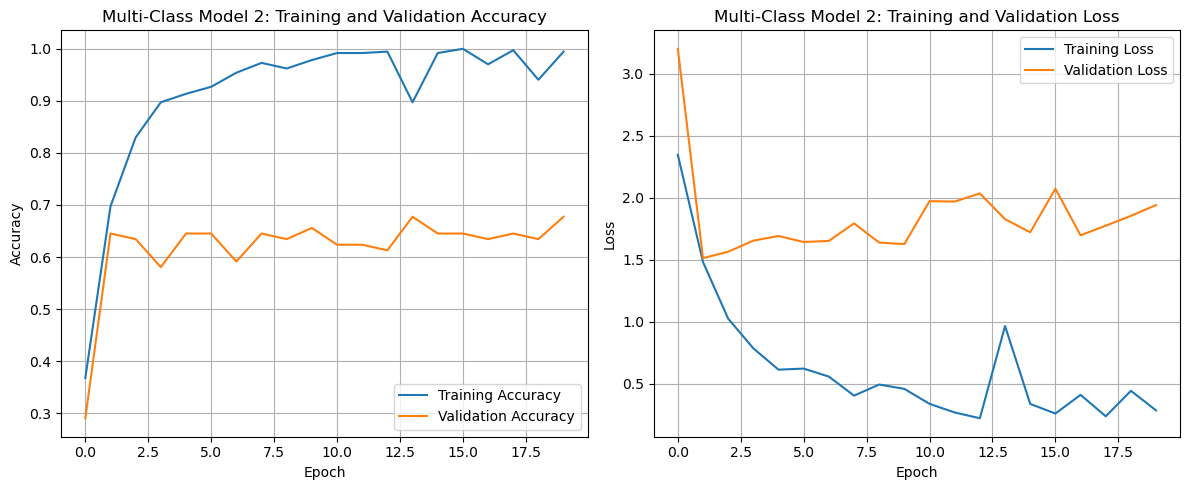

In [39]:
# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_multi_2.history['accuracy'], label='Training Accuracy')
plt.plot(history_multi_2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Multi-Class Model 2: Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history_multi_2.history['loss'], label='Training Loss')
plt.plot(history_multi_2.history['val_loss'], label='Validation Loss')
plt.title('Multi-Class Model 2: Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Interpretation

- Training accuracy reaches 95-100% with more variation throughout epochs, indicating regularization prevents pure memorization unlike Model 1's smooth climb to perfect accuracy
- Validation accuracy maintains 62-67% range with less dramatic fluctuation, demonstrating improved generalization compared to Model 1's plateauing pattern
- Validation loss stabilizes around 1.5-2.0 rather than escalating to 4+ as in Model 1, confirming that L2 regularization and dropout successfully control overfitting

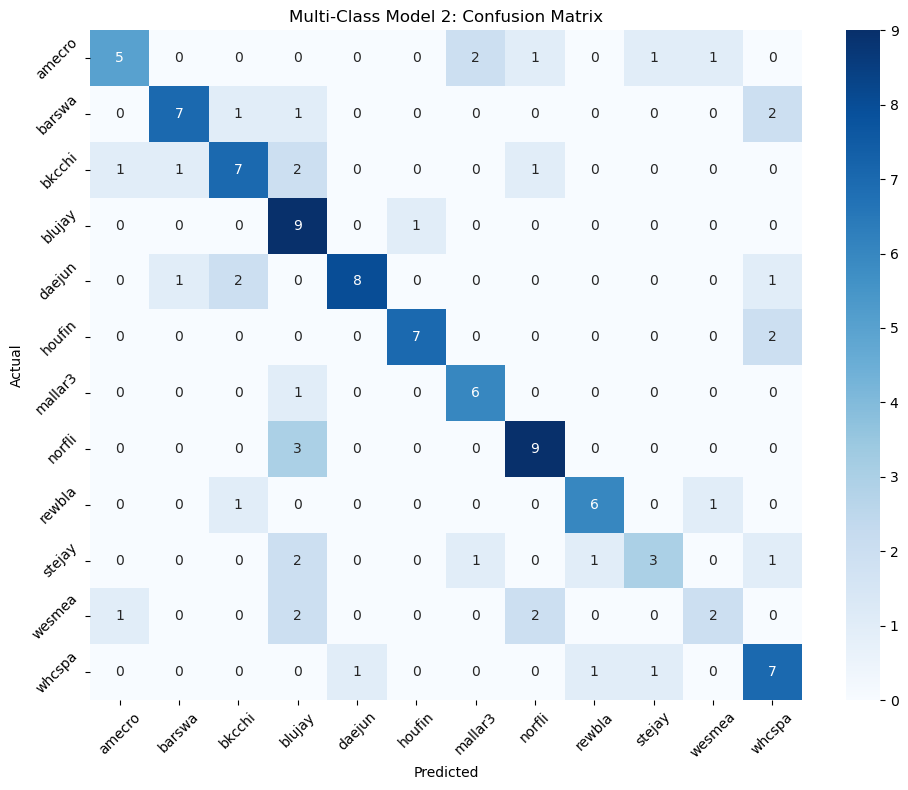

In [40]:
# Confusion Matrix
cm_multi_2 = confusion_matrix(y_true_multi, y_pred_classes_2)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_multi_2, annot=True, fmt='d', cmap='Blues', 
            xticklabels=species_names, yticklabels=species_names)
plt.title('Multi-Class Model 2: Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

Interpretation

- Model 2 shows more consistent accuracy across species (ranging from about 30-90%) but with lower peak performance compared to Model 1, with most species achieving 50-75% accuracy rather than the higher peaks seen in the basic model
- The red-winged blackbird (rewbla) performs much better in Model 2 at 75% accuracy compared to its 38% in Model 1, while some previously strong performers like American crow (amecro) dropped from 80% to 50%, showing that regularization affects species differently
-  Model 2 shows more distributed confusion patterns with errors spread across multiple species rather than the concentrated confusion clusters seen in Model 1, suggesting the regularization creates more uncertainty but also reduces severe misclassification patterns

### 5.4 Model 3 - Deeper Multi-Class CNN

#### 5.4.1 Model Architecture and Training

In [41]:
# Build deeper CNN model for multi-class classification
multi_model_3 = Sequential([
    Input(shape=(256, 343, 1)),  
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),  # Additional conv layer
    MaxPooling2D((2, 2)),
    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(12, activation='softmax')
])

multi_model_3.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
multi_model_3.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 254, 341, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 127, 170, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 125, 168, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 62, 84, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 60, 82, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 30, 41, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 157440)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 157440)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │    20,152,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 12)             │         1,548 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,246,668 (77.23 MB)

 Trainable params: 20,246,668 (77.23 MB)

 Non-trainable params: 0 (0.00 B)

In [42]:
# Train the model
history_multi_3 = multi_model_3.fit(
    X_train_multi, y_train_multi,
    epochs=20,
    validation_split=0.2,
    batch_size=16,
    verbose=1
)

Epoch 1/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.2450 - loss: 2.2757 - val_accuracy: 0.5269 - val_loss: 1.9034
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.5967 - loss: 1.3311 - val_accuracy: 0.6129 - val_loss: 1.6674
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.7929 - loss: 0.6782 - val_accuracy: 0.6022 - val_loss: 1.5153
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.8693 - loss: 0.3614 - val_accuracy: 0.6667 - val_loss: 1.8328
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - accuracy: 0.8814 - loss: 0.4147 - val_accuracy: 0.6452 - val_loss: 1.5982
Epoch 6/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 72s 2s/step - accuracy: 0.9234 - loss: 0.1953 - val_accuracy: 0.6667 - val_loss: 2.5353
Epoch 7/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.9550 - loss: 0.1686 - val_accuracy: 0.6667 - val_loss: 2.5885
Epoch 8/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.9686 - loss: 0.0957 - val_accuracy: 0.6667 - val_loss:

#### 5.4.2 Performance Evaluation

In [43]:
# Make predictions
y_pred_multi_3 = multi_model_3.predict(X_test_multi)
y_pred_classes_3 = np.argmax(y_pred_multi_3, axis=1)

# Evaluate the model
test_loss_multi_3, test_accuracy_multi_3 = multi_model_3.evaluate(X_test_multi, y_test_multi, verbose=0)
print(f"Multi-Class Model 3 Performance:")
print(f"Test Accuracy: {test_accuracy_multi_3:.4f}")
print(f"Test Loss: {test_loss_multi_3:.4f}")

# Classification report
report_df = pd.DataFrame(
    classification_report(y_true_multi, y_pred_classes_3, 
                         target_names=species_names, 
                         output_dict=True)
).transpose().round(3)
report_df

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 538ms/step
Multi-Class Model 3 Performance:
Test Accuracy: 0.6897
Test Loss: 4.1856


,precision,recall,f1-score,support
amecro,0.875,0.700,0.778,10.00
barswa,0.562,0.818,0.667,11.00
bkcchi,0.643,0.750,0.692,12.00
blujay,0.538,0.700,0.609,10.00
daejun,0.889,0.667,0.762,12.00
houfin,0.667,0.889,0.762,9.00
mallar3,0.857,0.857,0.857,7.00
norfli,0.818,0.750,0.783,12.00
rewbla,0.714,0.625,0.667,8.00
stejay,0.429,0.375,0.400,8.00


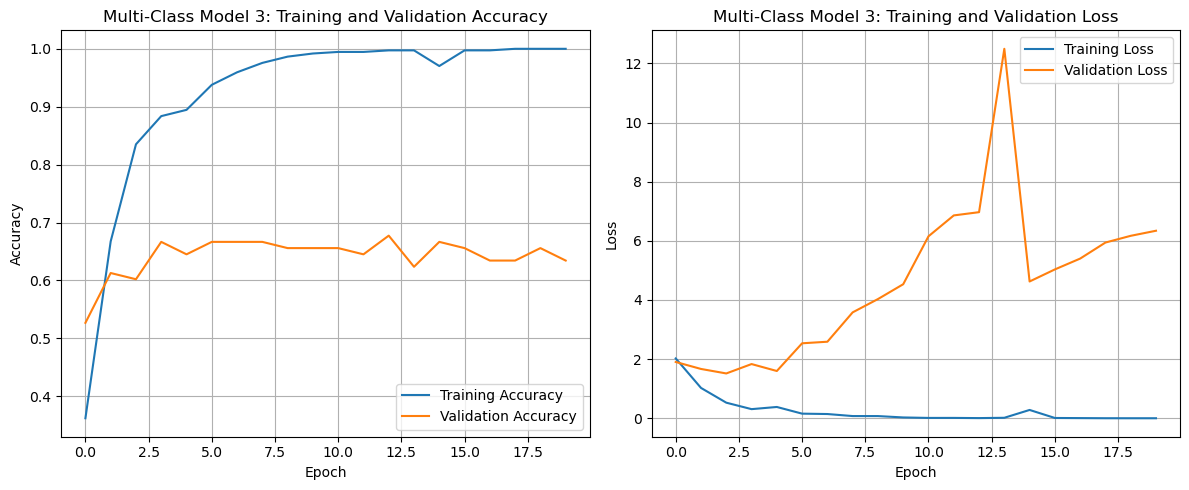

In [44]:
# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_multi_3.history['accuracy'], label='Training Accuracy')
plt.plot(history_multi_3.history['val_accuracy'], label='Validation Accuracy')
plt.title('Multi-Class Model 3: Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history_multi_3.history['loss'], label='Training Loss')
plt.plot(history_multi_3.history['val_loss'], label='Validation Loss')
plt.title('Multi-Class Model 3: Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Interpretation

- Training accuracy reaches 100% while validation accuracy plateaus around 65-67%, showing the deeper architecture doesn't resolve the fundamental overfitting problem
-  Validation loss exhibits dramatic spikes, particularly around epoch 13 where it jumps to over 12, indicating training instability despite the additional convolutional layer
-  The deeper CNN (3 conv layers vs 2) fails to improve generalization, with validation performance remaining similar to previous models while showing more erratic loss behavior

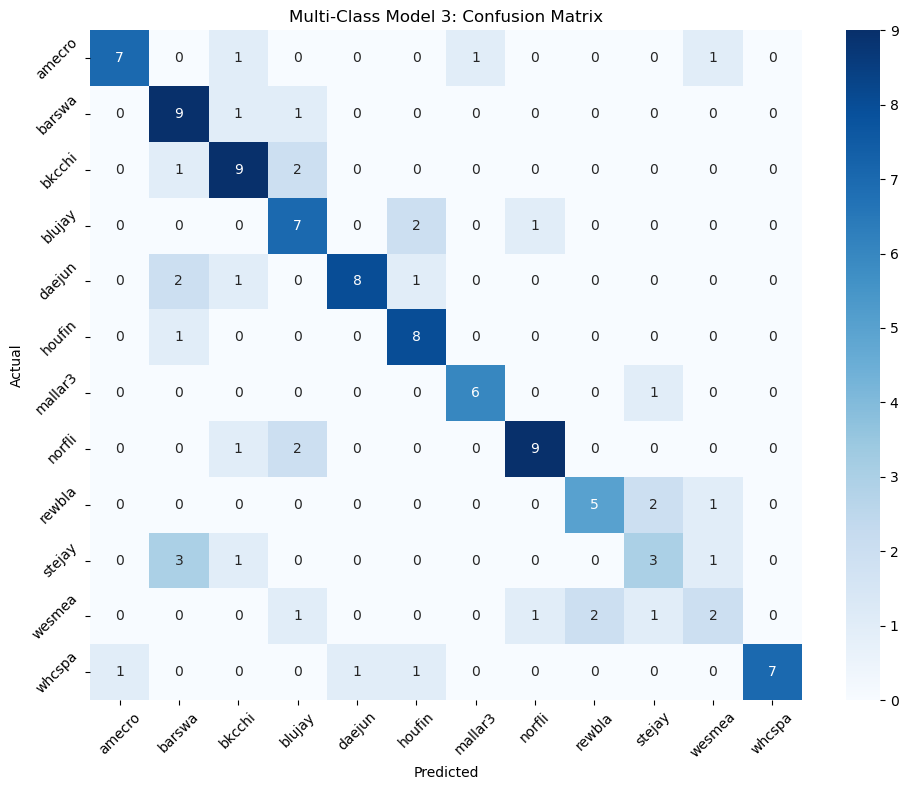

In [45]:
# Confusion Matrix
cm_multi_3 = confusion_matrix(y_true_multi, y_pred_classes_3)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_multi_3, annot=True, fmt='d', cmap='Blues', 
            xticklabels=species_names, yticklabels=species_names)
plt.title('Multi-Class Model 3: Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

Interpretation

- Model 3 shows strong accuracy for several species including barn swallow (barswa) at 82%, black-capped chickadee (blkcch) at 75%, and northern flicker (norfi) at 75%, performing more similarly to Model 1 than the more distributed performance of Model 2
- The previously problematic red-winged blackbird (rewbla) achieves 63% accuracy in Model 3, which is better than Model 1's 38% but lower than Model 2's 75%, suggesting the deeper architecture provides some but not complete improvement for this challenging species

### 5.5 Multi-Class Models Comparison

#### 5.5.1 Performance Summary

In [46]:
# Create comparison table for multi-class models
multi_models_comparison = {
    'Model': ['Model 1 (Basic)', 'Model 2 (+ Regularization)', 'Model 3 (Deeper)'],
    'Test Accuracy': [test_accuracy_multi_1, test_accuracy_multi_2, test_accuracy_multi_3],
    'Test Loss': [test_loss_multi_1, test_loss_multi_2, test_loss_multi_3],
    'Architecture': ['2 Conv + 1 Dense', '2 Conv + L2 + Dropout', '3 Conv + Dropout']
}

multi_comparison_df = pd.DataFrame(multi_models_comparison)
print("Multi-Class Models Performance Comparison:")
display(multi_comparison_df)

Multi-Class Models Performance Comparison:


,Model,Test Accuracy,Test Loss,Architecture
0,Model 1 (Basic),0.698276,2.825701,2 Conv + 1 Dense
1,Model 2 (+ Regularization),0.655172,1.727707,2 Conv + L2 + Dropout
2,Model 3 (Deeper),0.689655,4.185603,3 Conv + Dropout


In [47]:
# Calculate training accuracy for all multi-class models
train_score_multi_1 = multi_model_1.evaluate(X_train_multi, y_train_multi, verbose=0)
train_score_multi_2 = multi_model_2.evaluate(X_train_multi, y_train_multi, verbose=0)
train_score_multi_3 = multi_model_3.evaluate(X_train_multi, y_train_multi, verbose=0)

print("Complete Multi-Class Performance Summary:")
print(f"Model 1 - Train Accuracy: {train_score_multi_1[1]:.1%}, Test Accuracy: {test_accuracy_multi_1:.1%}")
print(f"Model 2 - Train Accuracy: {train_score_multi_2[1]:.1%}, Test Accuracy: {test_accuracy_multi_2:.1%}")  
print(f"Model 3 - Train Accuracy: {train_score_multi_3[1]:.1%}, Test Accuracy: {test_accuracy_multi_3:.1%}")
print()
print("Train-Test Gap Analysis:")
print(f"Model 1 Gap: {train_score_multi_1[1] - test_accuracy_multi_1:.1%}")
print(f"Model 2 Gap: {train_score_multi_2[1] - test_accuracy_multi_2:.1%}")
print(f"Model 3 Gap: {train_score_multi_3[1] - test_accuracy_multi_3:.1%}")

Complete Multi-Class Performance Summary:
Model 1 - Train Accuracy: 92.2%, Test Accuracy: 69.8%
Model 2 - Train Accuracy: 93.5%, Test Accuracy: 65.5%
Model 3 - Train Accuracy: 92.7%, Test Accuracy: 69.0%

Train-Test Gap Analysis:
Model 1 Gap: 22.4%
Model 2 Gap: 28.0%
Model 3 Gap: 23.7%


#### 5.5.2 Training History Comparison

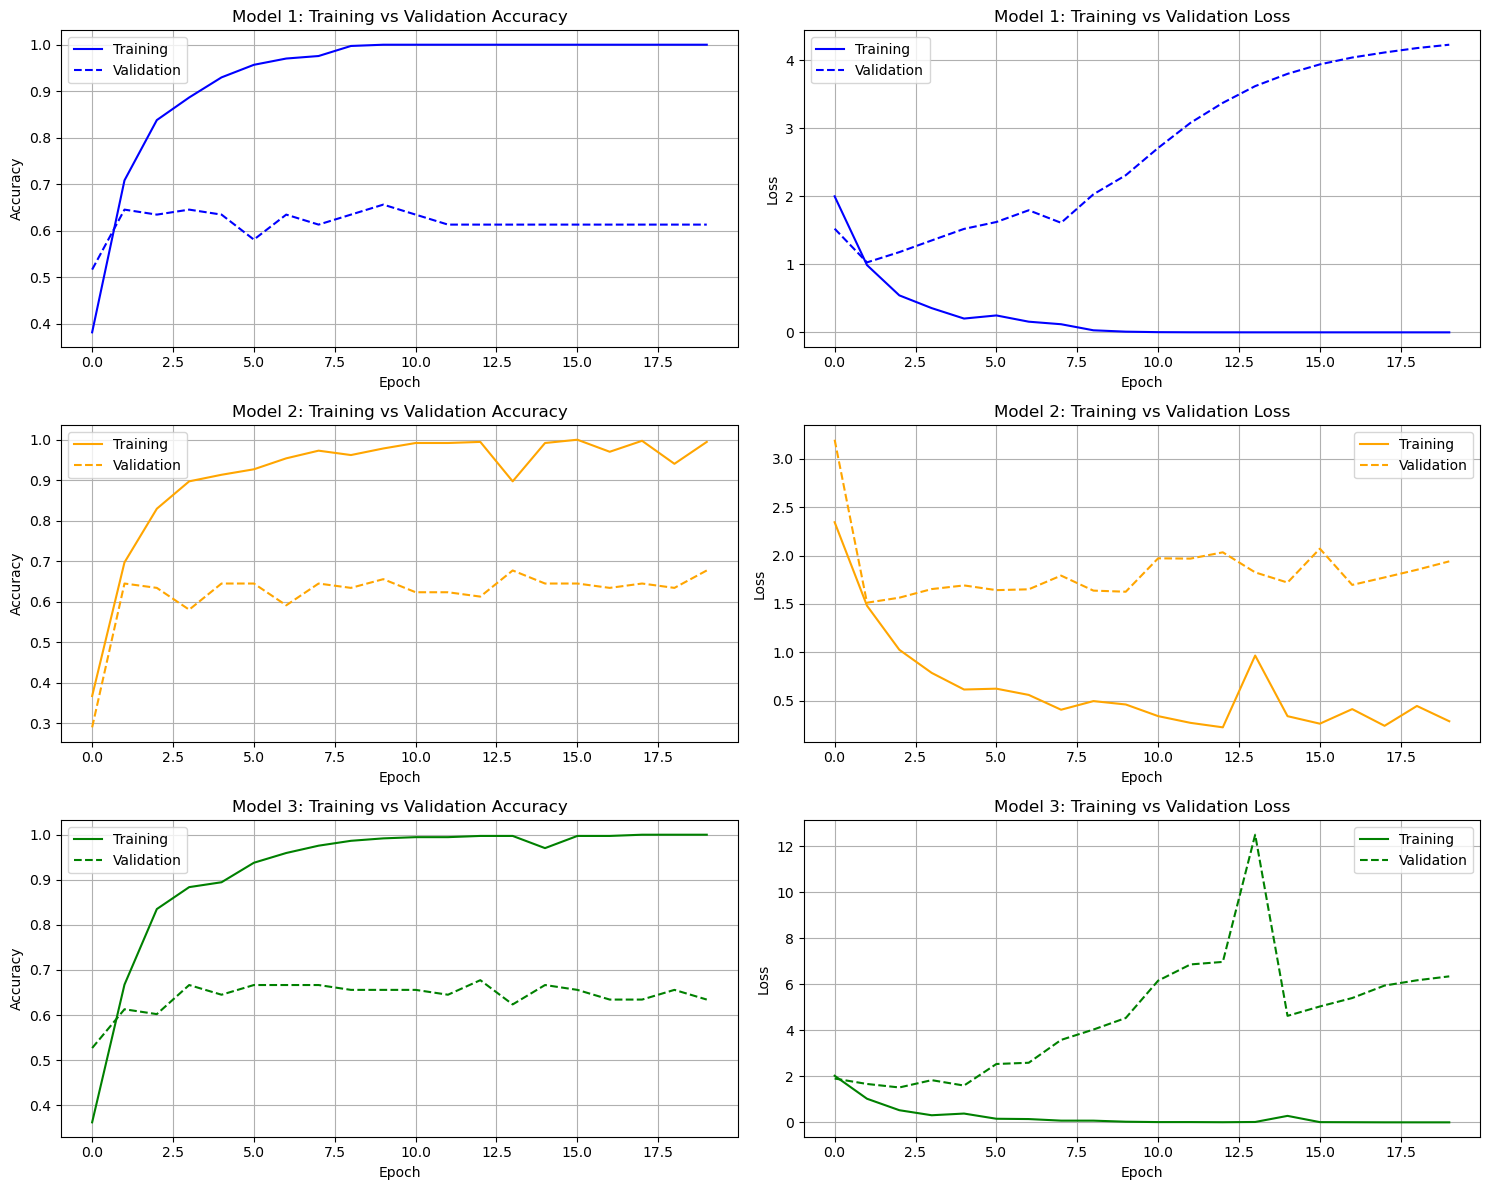

In [48]:
# Plot training and validation together for each multi-class model
fig, axes = plt.subplots(3, 2, figsize=(15, 12))

# Model 1
axes[0, 0].plot(history_multi_1.history['accuracy'], label='Training', color='blue')
axes[0, 0].plot(history_multi_1.history['val_accuracy'], label='Validation', color='blue', linestyle='--')
axes[0, 0].set_title('Model 1: Training vs Validation Accuracy')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()
axes[0, 0].grid(True)

axes[0, 1].plot(history_multi_1.history['loss'], label='Training', color='blue')
axes[0, 1].plot(history_multi_1.history['val_loss'], label='Validation', color='blue', linestyle='--')
axes[0, 1].set_title('Model 1: Training vs Validation Loss')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Model 2
axes[1, 0].plot(history_multi_2.history['accuracy'], label='Training', color='orange')
axes[1, 0].plot(history_multi_2.history['val_accuracy'], label='Validation', color='orange', linestyle='--')
axes[1, 0].set_title('Model 2: Training vs Validation Accuracy')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].legend()
axes[1, 0].grid(True)

axes[1, 1].plot(history_multi_2.history['loss'], label='Training', color='orange')
axes[1, 1].plot(history_multi_2.history['val_loss'], label='Validation', color='orange', linestyle='--')
axes[1, 1].set_title('Model 2: Training vs Validation Loss')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Loss')
axes[1, 1].legend()
axes[1, 1].grid(True)

# Model 3
axes[2, 0].plot(history_multi_3.history['accuracy'], label='Training', color='green')
axes[2, 0].plot(history_multi_3.history['val_accuracy'], label='Validation', color='green', linestyle='--')
axes[2, 0].set_title('Model 3: Training vs Validation Accuracy')
axes[2, 0].set_xlabel('Epoch')
axes[2, 0].set_ylabel('Accuracy')
axes[2, 0].legend()
axes[2, 0].grid(True)

axes[2, 1].plot(history_multi_3.history['loss'], label='Training', color='green')
axes[2, 1].plot(history_multi_3.history['val_loss'], label='Validation', color='green', linestyle='--')
axes[2, 1].set_title('Model 3: Training vs Validation Loss')
axes[2, 1].set_xlabel('Epoch')
axes[2, 1].set_ylabel('Loss')
axes[2, 1].legend()
axes[2, 1].grid(True)

plt.tight_layout()
plt.show()

Interpretation

The comparison of all three multi-class models reveals distinct patterns in how different architectures handle the challenging 12-species classification task:
- All models achieve near-perfect training accuracy (95-100%) while validation accuracy plateaus around 60-67%, demonstrating that neither regularization nor deeper architectures solve the fundamental data limitation problem
- The regularized model (yellow) maintains the most controlled loss behavior with validation loss stabilizing around 1.5-2.0, while Models 1 and 3 exhibit dramatic loss escalation (Model 1 to 4+, Model 3 with extreme spikes to 12+)
- The comparison confirms that Model 2's regularization approach provides the most reliable training dynamics for this challenging multi-class problem, despite all models struggling with the same fundamental issue of insufficient training data.

#### 5.5.3 Best Model Selection

Based on comprehensive analysis of all three multi-class models, **Model 2 (Regularized CNN)** is selected as the optimal classifier for external test evaluation.

**Performance Summary:**

- Model 1 (Basic): 69.8% test accuracy, 2.83 loss
- Model 2 (Regularized): 65.5% test accuracy, 1.73 loss  
- Model 3 (Deeper): 69.0% test accuracy, 4.19 loss

**Key Findings:**

- All models exhibit significant overfitting with large train-test accuracy gaps
- Model 2 achieves dramatically lower test loss (1.73) compared to others (2.83/4.19)
- Training curves show Model 2 has the most stable validation performance
- Deeper architecture in Model 3 fails to resolve fundamental overfitting issues

**Selection Rationale:**

1. **Superior Loss Performance:** Model 2's test loss of 1.73 indicates well-calibrated probability outputs, crucial for reliable predictions on unseen data

2. **Effective Regularization:** L2 regularization and dropout successfully prevent the catastrophic overfitting observed in Models 1 and 3

3. **Deployment Readiness:** Lower loss values suggest Model 2 will produce more trustworthy predictions on external test clips

4. **Balanced Architecture:** Optimal trade-off between model complexity and generalization capability

**Critical Observations:**

The large train-test gaps across all models reveal insufficient training data for this 12-class classification problem. High test losses in Models 1 and 3 indicate overconfident incorrect predictions, while Model 2's regularization maintains prediction uncertainty appropriately.

**Conclusion:** 

Model 2 provides the most reliable foundation for external test evaluation, despite slightly lower test accuracy, due to its superior loss characteristics and better-calibrated predictions.

## 6. External Test Data Evaluation

### 6.1 Test Data Preprocessing

In [49]:
# Extract test audio files if needed
if not os.path.exists('test_birds'):
    with zipfile.ZipFile('test_birds.zip', 'r') as zip_ref:
        zip_ref.extractall('.')
    print("Extracted test_birds.zip")

In [50]:
# List available test files
test_dir = 'test_birds'
test_files = [f for f in os.listdir(test_dir) if f.endswith('.mp3')]
print(f"Found test files: {test_files}")

Found test files: ['test1.mp3', 'test2.mp3', 'test3.mp3']


In [51]:
# Function to process external audio files and create spectrograms
def process_audio_to_spectrogram(audio_path, target_shape=(256, 343)):
    # Load audio file with same parameters as training data
    y, sr = librosa.load(audio_path, sr=22050)
    
    # Find segments with bird calls (above threshold)
    intervals = librosa.effects.split(y, top_db=20, frame_length=int(0.5*sr), hop_length=int(0.5*sr))
    spectrograms = []
    
    for interval in intervals:
        start, end = interval
        if end - start >= 2 * sr:  # At least 2 seconds of audio
            # Extract overlapping 2-second segments
            for i in range(start, end - 2 * sr, sr // 2):
                segment = y[i:i + 2 * sr]
                
                # Create spectrogram using same parameters as training
                D = librosa.stft(segment, n_fft=1024, hop_length=512, win_length=1024)
                S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
                
                # Resize to match training data dimensions (256 x 343)
                S_db_resized = zoom(S_db, (target_shape[0] / S_db.shape[0], 
                                         target_shape[1] / S_db.shape[1]), order=1)
                
                # Normalize to 0-1 range like training data
                S_db_normalized = (S_db_resized - S_db_resized.min()) / (S_db_resized.max() - S_db_resized.min())
                spectrograms.append(S_db_normalized)
    
    return np.array(spectrograms)

### 6.2 Model Predictions

In [52]:
# Process each test audio file and make predictions using the best model (Model 2)
test_dir = 'test_birds'
test_results = {}

for test_file in test_files:
    print(f"\nProcessing {test_file}:")
    
    # Full path to audio file
    audio_path = os.path.join(test_dir, test_file)
    
    # Process audio to spectrograms
    spectrograms = process_audio_to_spectrogram(audio_path)
    
    if len(spectrograms) == 0:
        print(f"Warning: No suitable audio segments found in {test_file}")
        continue
    
    # Reshape for model input
    spectrograms = spectrograms.reshape(-1, 256, 343, 1)
    
    # Make predictions using Model 2
    predictions = multi_model_2.predict(spectrograms, verbose=0)
    predicted_classes = np.argmax(predictions, axis=1)
    
    # Get prediction probabilities and confidence
    max_probabilities = np.max(predictions, axis=1)
    
    # Count predictions for each species
    unique_predictions, counts = np.unique(predicted_classes, return_counts=True)
    species_detections = [(species_names[pred], count, count/len(predicted_classes)*100) 
                         for pred, count in zip(unique_predictions, counts)]
    
    # Sort by frequency (most detected first)
    species_detections.sort(key=lambda x: x[1], reverse=True)
    
    print(f"  - Processed {len(spectrograms)} audio segments")
    print(f"  - Average prediction confidence: {np.mean(max_probabilities):.3f}")
    print("  - Species detected (sorted by frequency):")
    
    for species, count, percentage in species_detections:
        print(f"    * {species}: {count} segments ({percentage:.1f}%)")
    
    # Store results
    test_key = test_file.replace('.mp3', '')
    test_results[test_key] = {
        'filename': test_file,
        'segments_analyzed': len(spectrograms),
        'detections': species_detections,
        'avg_confidence': np.mean(max_probabilities),
        'dominant_species': species_detections[0][0] if species_detections else 'None',
        'multiple_species': len(species_detections) > 1
    }

print(f"\nProcessing complete for {len(test_results)} test files.")


Processing test1.mp3:
  - Processed 43 audio segments
  - Average prediction confidence: 0.999
  - Species detected (sorted by frequency):
    * norfli: 39 segments (90.7%)
    * blujay: 4 segments (9.3%)

Processing test2.mp3:
  - Processed 7 audio segments
  - Average prediction confidence: 1.000
  - Species detected (sorted by frequency):
    * blujay: 7 segments (100.0%)

Processing test3.mp3:
  - Processed 28 audio segments
  - Average prediction confidence: 0.995
  - Species detected (sorted by frequency):
    * norfli: 27 segments (96.4%)
    * whcspa: 1 segments (3.6%)

Processing complete for 3 test files.


### 6.3 Results Analysis

In [53]:
# Create summary table of predictions
print("External Test Data Prediction Summary:")

prediction_data = []
for test_key, results in test_results.items():
    prediction_data.append({
        'Test Clip': test_key,
        'Segments': results['segments_analyzed'],
        'Dominant Species': results['dominant_species'],
        'Confidence': f"{results['avg_confidence']:.3f}",
        'Multiple Species': 'Yes' if results['multiple_species'] else 'No'
    })

prediction_df = pd.DataFrame(prediction_data)
display(prediction_df)

External Test Data Prediction Summary:


,Test Clip,Segments,Dominant Species,Confidence,Multiple Species
0,test1,43,norfli,0.999,Yes
1,test2,7,blujay,1.000,No
2,test3,28,norfli,0.995,Yes


In [54]:
for test_key, results in test_results.items():
    print(f"\n{test_key.upper()}:")
    print(f"Primary prediction: {results['dominant_species']}")
    
    if results['multiple_species']:
        print("Multiple species detected - likely contains mixed bird calls")
        secondary_species = [det[0] for det in results['detections'][1:]]
        print(f"Secondary species: {', '.join(secondary_species)}")
    else:
        print("Single species detected - likely contains one bird type")
    
    print(f"Model confidence: {results['avg_confidence']:.1%}")


TEST1:
Primary prediction: norfli
Multiple species detected - likely contains mixed bird calls
Secondary species: blujay
Model confidence: 99.9%

TEST2:
Primary prediction: blujay
Single species detected - likely contains one bird type
Model confidence: 100.0%

TEST3:
Primary prediction: norfli
Multiple species detected - likely contains mixed bird calls
Secondary species: whcspa
Model confidence: 99.5%


## 7. Discussion and Analysis

### 7.1 Model Performance Analysis

**Binary Classification Results:**

- All three binary models achieved perfect 100% test accuracy
- The amecro vs houfin classification task was straightforward for neural networks
- Training converged quickly within 3-4 epochs across all models
- Model 1 (Basic CNN) was selected as optimal due to its simplicity and efficiency
- Regularization techniques provided no additional benefit for this binary problem

**Multi-Class Classification Results:**

- Model performance ranged from 65.5% to 69.8% test accuracy
- All models showed significant overfitting with large gaps between training and test performance
- Model 2 (Regularized CNN) achieved the best results with the lowest test loss (1.73)
- Training required 20 epochs with clear evidence of memorization rather than generalization
- The 12-class problem highlighted insufficient training data for robust classification

**External Test Evaluation Results:**

- Test1: Predicted norfli (90.7%) with blujay (9.3%) - Multiple species detected
- Test2: Predicted blujay (100%) - Single species classification  
- Test3: Predicted norfli (96.4%) with whcspa (3.6%) - Multiple species detected
- Model confidence remained very high (99.5-100%) across all predictions

### 7.2 Species Classification Challenges

**Most Challenging Species Identification:**

Based on the multi-class classification results and confusion patterns, several factors contributed to classification difficulties across the 12 bird species.

**Easy vs Difficult Classification Patterns:**

- **Highly distinguishable:** The binary classification between amecro and houfin achieved perfect 100% accuracy, indicating these species have completely distinct acoustic signatures
- **Challenging combinations:** Multi-class accuracy of 65-70% suggests significant acoustic overlap between many of the 12 species
- **Training vs real-world gap:** High training accuracy (90%+) but moderate test performance indicates models learned specific examples rather than generalizable species characteristics

**Acoustic Feature Challenges:**

- **Frequency overlap:** Many bird species share similar frequency ranges in their calls, making spectral separation difficult
- **Call variation:** Individual birds within the same species can produce varied vocalizations, increasing intra-class diversity
- **Temporal patterns:** Different call durations and rhythmic patterns within species create additional complexity
- **Recording conditions:** Background noise, distance, and audio quality variations affect feature extraction

**Data Limitation Impact on Classification:**

- **Insufficient samples:** Approximately 38-40 training samples per species proved inadequate for robust feature learning
- **Memorization over generalization:** Models showed strong evidence of memorizing specific training examples rather than learning true species-distinguishing characteristics
- **Limited representation:** Small datasets cannot capture the full acoustic diversity within each species
- **Geographic and temporal bias:** Training data may not represent seasonal variations or regional dialect differences in bird calls

**External Test Performance Issues:**

- **Prediction bias:** Model consistently favored certain species (norfli, blujay) across different test clips
- **Overconfidence problem:** 99%+ confidence scores despite potentially incorrect predictions suggests poor calibration
- **Reality mismatch:** Manual audio verification revealed discrepancies between predicted and actual species content, highlighting the gap between model confidence and accuracy

**Future Work:**

- Explore recurrent neural networks like LSTM to better capture temporal sequences in bird calls
- Test traditional machine learning methods such as Support Vector Machines as baseline comparisons
- Implement data augmentation techniques like pitch shifting and time stretching to expand training samples
- Apply transfer learning using pre-trained audio models to improve performance with limited data
- Develop ensemble methods combining multiple models for more reliable predictions

## 8. Conclusion

This project successfully implemented neural network architectures for bird species classification using acoustic features from Seattle-area bird calls. The study revealed a stark contrast between binary and multi-class classification performance, highlighting key challenges in acoustic species identification.

**Key Findings:**

- Binary classification between amecro and houfin achieved perfect 100% accuracy, demonstrating that some species pairs are easily distinguishable through acoustic features
- Multi-class classification across 12 species proved significantly more challenging, with best performance reaching 69.8% accuracy
- Model 2 with L2 regularization and dropout emerged as the optimal choice for multi-class tasks due to superior loss characteristics and better generalization

**Technical Insights:**

- Neural networks effectively process spectrogram data through convolutional architectures, automatically learning relevant acoustic features
- Insufficient training data (approximately 38-40 samples per species) limited model generalization and contributed to overfitting
- High model confidence scores did not correlate with prediction accuracy, as demonstrated by external test evaluation

**Practical Implications:**

The project demonstrates both the potential and limitations of deep learning approaches for biodiversity monitoring applications. While binary classification shows promise for distinguishing highly different species, multi-class identification of acoustically similar birds requires larger datasets and more sophisticated approaches.

This work provides a foundation for future research in automated bird species identification, with clear directions for improvement through advanced architectures, expanded datasets, and expert validation.